In [2]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
import itertools
import pickle

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from picking.p_picking import p_picking_all, p_picking_each, p_picking_val
from picking.utils import optimize_parameters, load_best_params
from picking.plot import *


/home/lptv/anaconda3/envs/trigger_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def find_files(path, extensions):
    '''
    Entrega de vuelta un diccionario con la extensión del archivo como llave, y el path a cada archivo como valor

    '''
    file_list = {ext: [] for ext in list(extensions)}
    for root, dirs, files in os.walk(path):
        for file in files:
            for ext in extensions:
                if file.endswith(ext):
                    file_list[ext].append(os.path.join(root, file))

    return file_list


def sort_files(file_dic, extension):
    '''
    Junta los archivos por carpeta y canal. Queda un diccionario que tiene como llave la carpeta y el canal, 
    y como valor una lista con los paths a los archivos de esa carpeta y canal.   
    '''
    # Diccionario para almacenar los archivos por carpeta y canal
    grouped_files = defaultdict(list)
    key_names = []
    
    # Ordenar los archivos alfabéticamente antes de procesarlos
    sorted_files = sorted(file_dic[extension])
    
    for file in sorted_files:
        # Extraer la carpeta y el canal del path del archivo
        parts = os.path.split(file)
        folder = parts[0]  # La carpeta es el primer elemento en el path
        channel = parts[1].split('_')[0]  # El canal es el primer elemento en el nombre del archivo
        key = os.path.join(folder, channel)
        if [key] not in key_names:
            key_names.append([key])
        # Agrupar los archivos
        grouped_files[key].append(file)

    key_names = list(itertools.chain(*key_names))
    return grouped_files, key_names




In [4]:
files_bhz = find_files("señales_sismos/BHZ", ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

<img src="diagrama.png">

# 1. Preprocesamiento de las trazas

## 1.1. Lectura de las trazas sísmicas

***Ojo que la forma en que se ordenan las cosas es diferente en windows y linux, no se por què, ver esto***
- En la diferencia entre los archivos sta-lta.ipynb y energy.ipynb se van a evidencia las diferencias.
- Una es en la // de las funciones find_files y sort_files
- La otra es en aca abajo en como quedan ordenadas las trazas. AC04 quedan en 2 y CO05 queda en 0.

In [5]:
#estación AC04
AC04_st = files_bhz_ch[key_names_bhz[0]]
st_AC04_raw = read(AC04_st[0])
st_AC04_raw += read(AC04_st[1])
st_AC04_raw += read(AC04_st[2])


#estación adyacente 1: AC05
AC05_st = files_bhz_ch[key_names_bhz[1]]
st_AC05_raw = read(AC05_st[0])
st_AC05_raw += read(AC05_st[1])
st_AC05_raw += read(AC05_st[2])


#estación adyacente 2: CO05
CO05_st = files_bhz_ch[key_names_bhz[2]]
st_CO05_raw = read(CO05_st[0])
st_CO05_raw += read(CO05_st[1])
st_CO05_raw += read(CO05_st[2])

#estación adyacente 3: CO10
CO10_st = files_bhz_ch[key_names_bhz[3]]
st_CO10_raw = read(CO10_st[0])
st_CO10_raw += read(CO10_st[1])
st_CO10_raw += read(CO10_st[2])

### 1.1.1. Visualización de la señal AC04

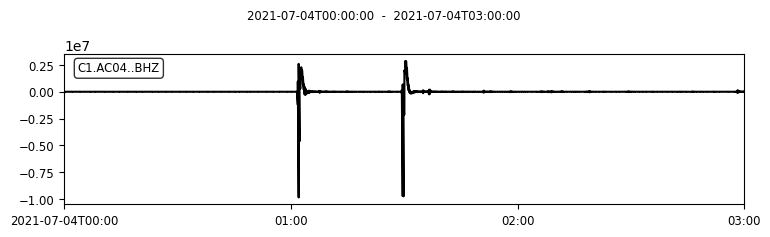

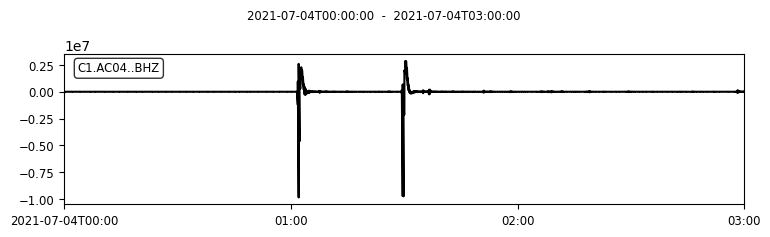

In [6]:
st_AC04_raw[2].plot(startime = st_AC04_raw[2].stats.starttime + 60*60 , endtime = st_AC04_raw[2].stats.starttime + 60*60*3)

## 1.2. Eliminación de respuesta de instrumentos

In [7]:
def remove_response(trace: Trace, inventory_filepath: str, remove_type: str = "obspy"):
    """
    Remove instrument response

    Args:
        trace (Trace): Trace object from obspy
        inventory_folder (str): Path to inventory folder
    """
    from obspy import read_inventory

    assert isinstance(trace, Trace), "trace must be a Trace object from obspy"

    trace_removed = trace.copy()

    inv = read_inventory(inventory_filepath)
        # Remove instrument response
    if remove_type == "obspy":
        trace_removed.remove_response(
            inventory=inv,
            output="VEL",
            zero_mean=False,
        )
    elif remove_type == "scalar":
        resp = inv.get_response(seed_id=trace_removed.get_id(), datetime=trace_removed.stats.starttime)
        #trace_removed.data *= 1/inv[0][0].response.instrument_sensitivity.value
        trace_removed.data *= 1/resp.instrument_sensitivity.value
        
    """inv = read_inventory(inventory_filepath)
        resp = inv.get_response(
            seed_id=trace_removed.get_id(), 
            datetime=trace_removed.stats.starttime)
        poles = resp.get_paz().poles
        zeros = resp.get_paz().zeros
        #gain = np.prod(list(map(lambda stage: stage.stage_gain, resp.response_stages)))
        sensitivity = resp.instrument_sensitivity.value
        for stage in resp.response_stages[::-1]:
            gain = stage.stage_gain
            paz_sts2 = {'poles': poles,
                'zeros': zeros,
                'gain': 1/gain,
                'sensitivity': sensitivity}
            trace_removed.simulate(paz_remove=paz_sts2)"""

    return trace_removed

In [8]:
remove_AC04 = os.path.join("inventory", "C1_AC04.xml")
remove_AC05 = os.path.join("inventory", "C1_AC05.xml")
remove_CO05 = os.path.join("inventory", "C1_CO05.xml")
remove_CO10 = os.path.join("inventory", "C1_CO10.xml")

In [9]:
st_AC04_resp = st_AC04_raw.copy()
st_AC05_resp = st_AC05_raw.copy()
st_CO05_resp = st_CO05_raw.copy()
st_CO10_resp = st_CO10_raw.copy()

In [10]:
st_AC04_removed = remove_response(st_AC04_resp.select(channel='BHZ')[0], remove_AC04 , 'obspy')
st_AC05_removed = remove_response(st_AC05_resp.select(channel='BHZ')[0], remove_AC05 , 'obspy')
st_CO05_removed = remove_response(st_CO05_resp.select(channel='BHZ')[0], remove_CO05 , 'obspy')
st_CO10_removed = remove_response(st_CO10_resp.select(channel='BHZ')[0], remove_CO10 , 'obspy')

st_AC04_resp[2] = st_AC04_removed
st_AC05_resp[2] = st_AC05_removed
st_CO05_resp[2] = st_CO05_removed 
st_CO10_resp[2] = st_CO10_removed

assert(st_AC04_resp.select(channel='BHZ')[0] == st_AC04_removed)
assert(st_AC05_resp.select(channel='BHZ')[0] == st_AC05_removed)
assert(st_CO05_resp.select(channel='BHZ')[0] == st_CO05_removed)
assert(st_CO10_resp.select(channel='BHZ')[0] == st_CO10_removed)

### 1.2.1. Visualización señal sin respuesta instrumental

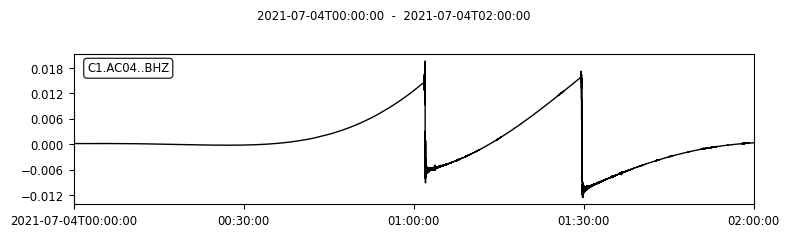

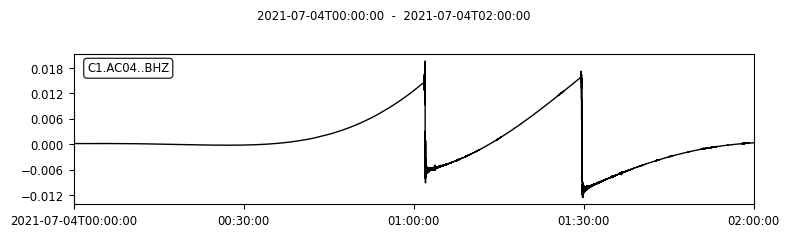

In [10]:
st_AC04_resp[2].plot(startime = st_AC04_resp[2].stats.starttime + 60*60, endtime = st_AC04_resp[2].stats.starttime + 2*60*60)

## 1.3. Filtro pasa banda

In [11]:
st_AC04 = st_AC04_resp.copy()
st_AC05 = st_AC05_resp.copy()
st_CO05 = st_CO05_resp.copy()
st_CO10 = st_CO10_resp.copy()

In [12]:
st_AC04.filter('bandpass', freqmin=4.0, freqmax=10.0) 
st_AC05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO10.filter('bandpass', freqmin=4.0, freqmax=10.0)

3 Trace(s) in Stream:
C1.CO10..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

### 1.3.1 Visualización señal filtrada 

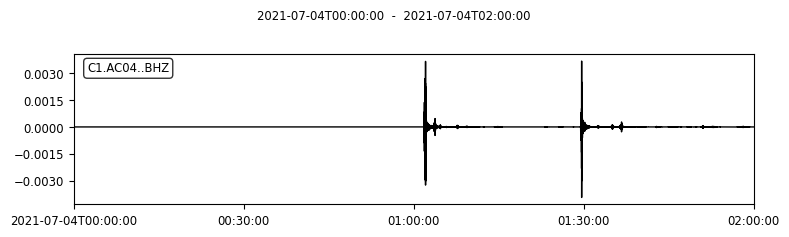

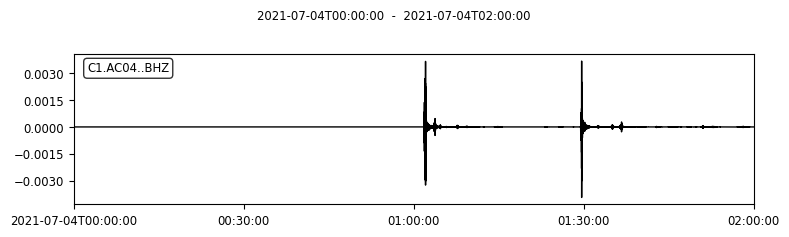

In [13]:
st_AC04[2].plot(startime = st_AC04[2].stats.starttime, endtime = st_AC04[2].stats.starttime + 60*60*2)

# 2. Cálculo de la energía para los eventos mayores que 4 en la estación más cercana al evento.

## 2.1. Cargamos el txt con los eventos mayores que 4. Este archivo ya viene con las distancias de los eventos a cada estación

In [14]:
# Ruta al archivo txt
file_path = "times_events_24hrs_sup40.txt"  # reemplaza esto con la ruta a tu archivo txt

# Lee los datos
df = pd.read_csv(file_path)

## 2.2 Guardamos en un diccionario la estación y tiempo de detección del evento en esa estación, para todos los eventos

In [15]:


# Inicializa un diccionario vacío para guardar los resultados
resultados = {}

stations = ['AC04', 'AC05', 'CO05', 'CO10']

# Itera sobre cada fila del DataFrame
for i, fila in df.iterrows():
    # Obtiene las distancias a las estaciones
    distancias = [fila['Distancia a estación AC04'], fila['Distancia a estación AC05'], fila['Distancia a estación CO05'], fila['Distancia a estación CO10']]
    
    # Obtiene las horas de detección en las estaciones
    horas_deteccion = [fila['Hora detección estación AC04'], fila['Hora detección estación AC05'], fila['Hora detección estación CO05'], fila['Hora detección estación CO10']]
    
    # Encuentra el índice de la estación más cercana
    indice_estacion_cercana = distancias.index(min(distancias))
    
    # Guarda la estación más cercana y la hora de detección correspondiente en el diccionario
    resultados[i+1] = [stations[indice_estacion_cercana], horas_deteccion[indice_estacion_cercana]]



## 2.3. Creamos una lista con el tiempo de partida de cada evento para la estación más cercana y una lista con el nombre de la estación más cercana para cada evento

In [16]:
start_time = [UTCDateTime(resultados[clave][1]) for clave in sorted(resultados)]
closest_st_names = [resultados[clave][0] for clave in sorted(resultados)]

## 2.4. Se selecciona el canal de mayor interes para todas las estaciones

In [17]:
#selecciona el canal BHZ de AC04
st_AC04_BHZ = st_AC04.select(channel='BHZ')
#selecciona el canal BHZ de AC05
st_AC05_BHZ = st_AC05.select(channel='BHZ')
#selecciona el canal BHZ de CO05
st_CO05_BHZ = st_CO05.select(channel='BHZ')
#selecciona el canal BHZ de CO10
st_CO10_BHZ = st_CO10.select(channel='BHZ')

## 2.5 Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

In [18]:
# Crear un diccionario para mapear los nombres de las estaciones a las estaciones
stations = {
    'AC04': st_AC04_BHZ[0],
    'AC05': st_AC05_BHZ[0],
    'CO05': st_CO05_BHZ[0],
    'CO10': st_CO10_BHZ[0],
}

# Crear una lista con las estaciones más cercanas para cada evento
closest_sts_tr = [stations[estacion] for estacion in closest_st_names]


In [19]:
closest_sts_tr

[C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 H

## 2.6. Se toma para cada evento un rango de tiempo alrededor de la detección estimada y luego se visualiza

In [20]:
pre_event = 10
post_event = 60

sliced_sts = [sts.slice(start - pre_event, start+post_event) for sts, start in zip(closest_sts_tr, start_time)]

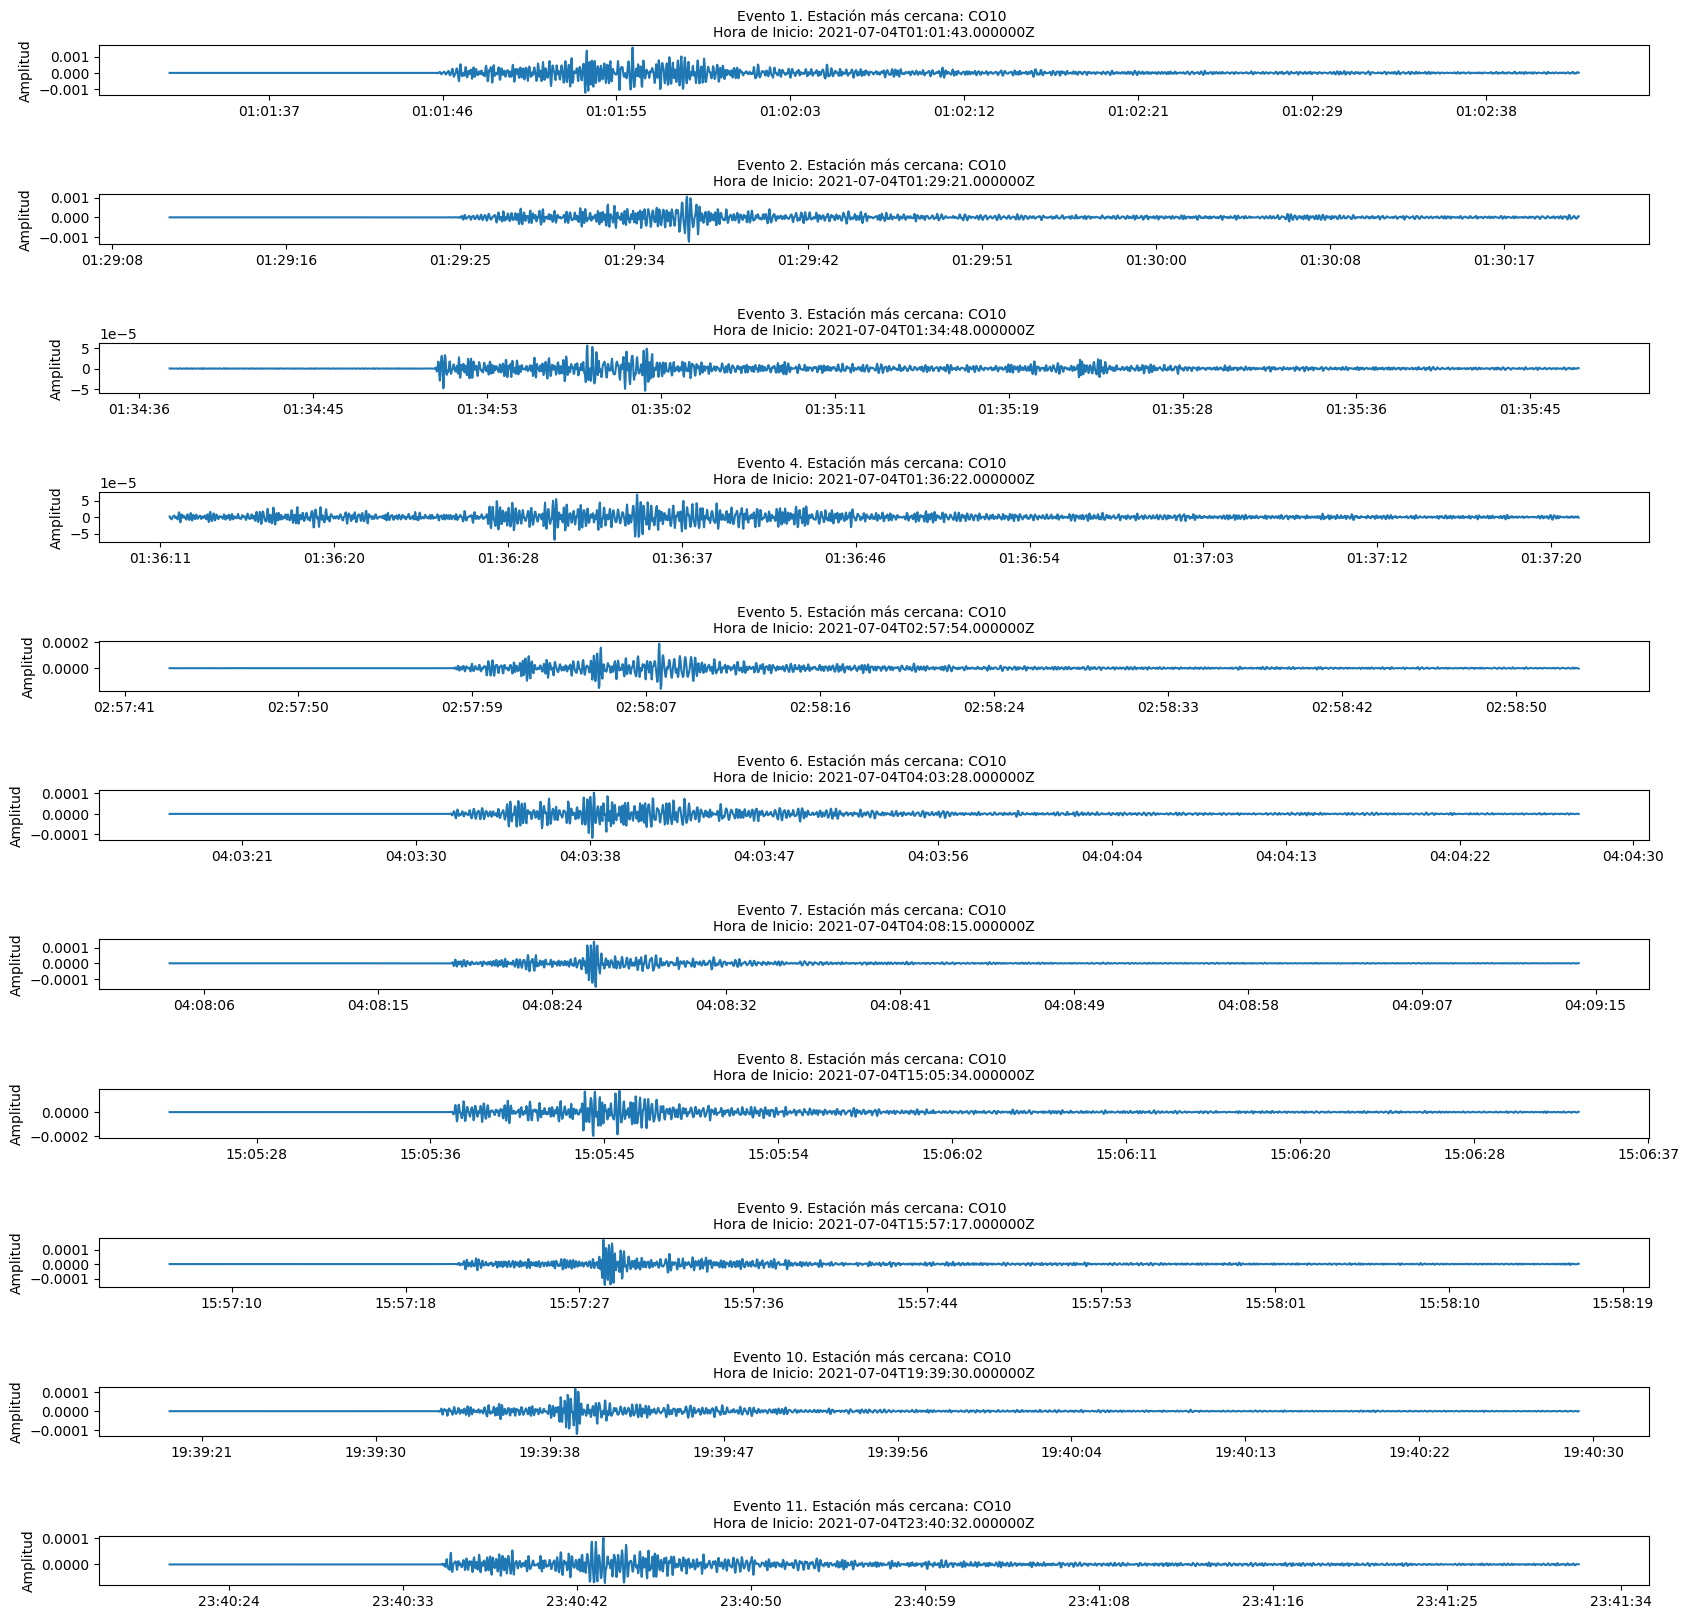

In [21]:
fig, axs = plt.subplots(len(sliced_sts), 1, figsize=(20, 20), sharex=False)
fig.subplots_adjust(hspace = 2)

for i, sts in enumerate(sliced_sts):
    axs[i].plot(sts.times("matplotlib"), sts.data)
    axs[i].set_title(f'Evento {i+1}. Estación más cercana: {closest_st_names[i]} \nHora de Inicio: {sts.stats.starttime + pre_event}', size=10)
    axs[i].set_ylabel('Amplitud')
    axs[i].set_xlim([axs[i].get_xlim()[0], axs[i].get_xlim()[1]])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

plt.show()





# 3. Cálculo de la energía suavizada.

## 3.1 Esta función devuelve el array con la energía, el punto de la traza tomada donde se encuentra el maximo de energía, y también el punto donde la energía de la señal baja del 3% de la energía máxima después del evento 

In [154]:
# a tener en consideración 32^MAGNITUD DEL SISMO

In [24]:
data = np.array([1,2,3,4,2,3,2,1,5,6])

In [33]:
e = np.convolve(data**2, np.ones(2)/2, mode='valid')
p = np.mean(e)
p1 = e / (2*2/40)
print(e)
print(p1)

[ 2.5  6.5 12.5 10.   6.5  6.5  2.5 13.  30.5]
[ 25.  65. 125. 100.  65.  65.  25. 130. 305.]


In [34]:
def energy_power(signal, window_size, sample_rate = 40, thr_energy = 0.03):

    # Multiplicamos por un factor de escala para evitar errores numericos por trabajar con números muy pequeños
    data = signal*1e5

    # Calcular la energía en cada punto
    energy = np.convolve(data**2, np.ones(window_size)/window_size, mode='valid')

    # Encontrar el pico de energía
    max_energy = np.max(energy)
    peak_index_energy = np.argmax(energy)

    # Calcular el 3% del pico de energía
    threshold_energy = thr_energy * max_energy

    # Encontrar el punto donde la señal baja del 3% después del pico
    for i in range(peak_index_energy, len(energy)):
        if energy[i] < threshold_energy:
            endpoint_energy = i
            break

    # Calcular la potencia como la tasa de cambio de energía con respecto al tiempo
    power = energy / (2 * window_size / sample_rate)

    return energy, power, peak_index_energy, endpoint_energy
    

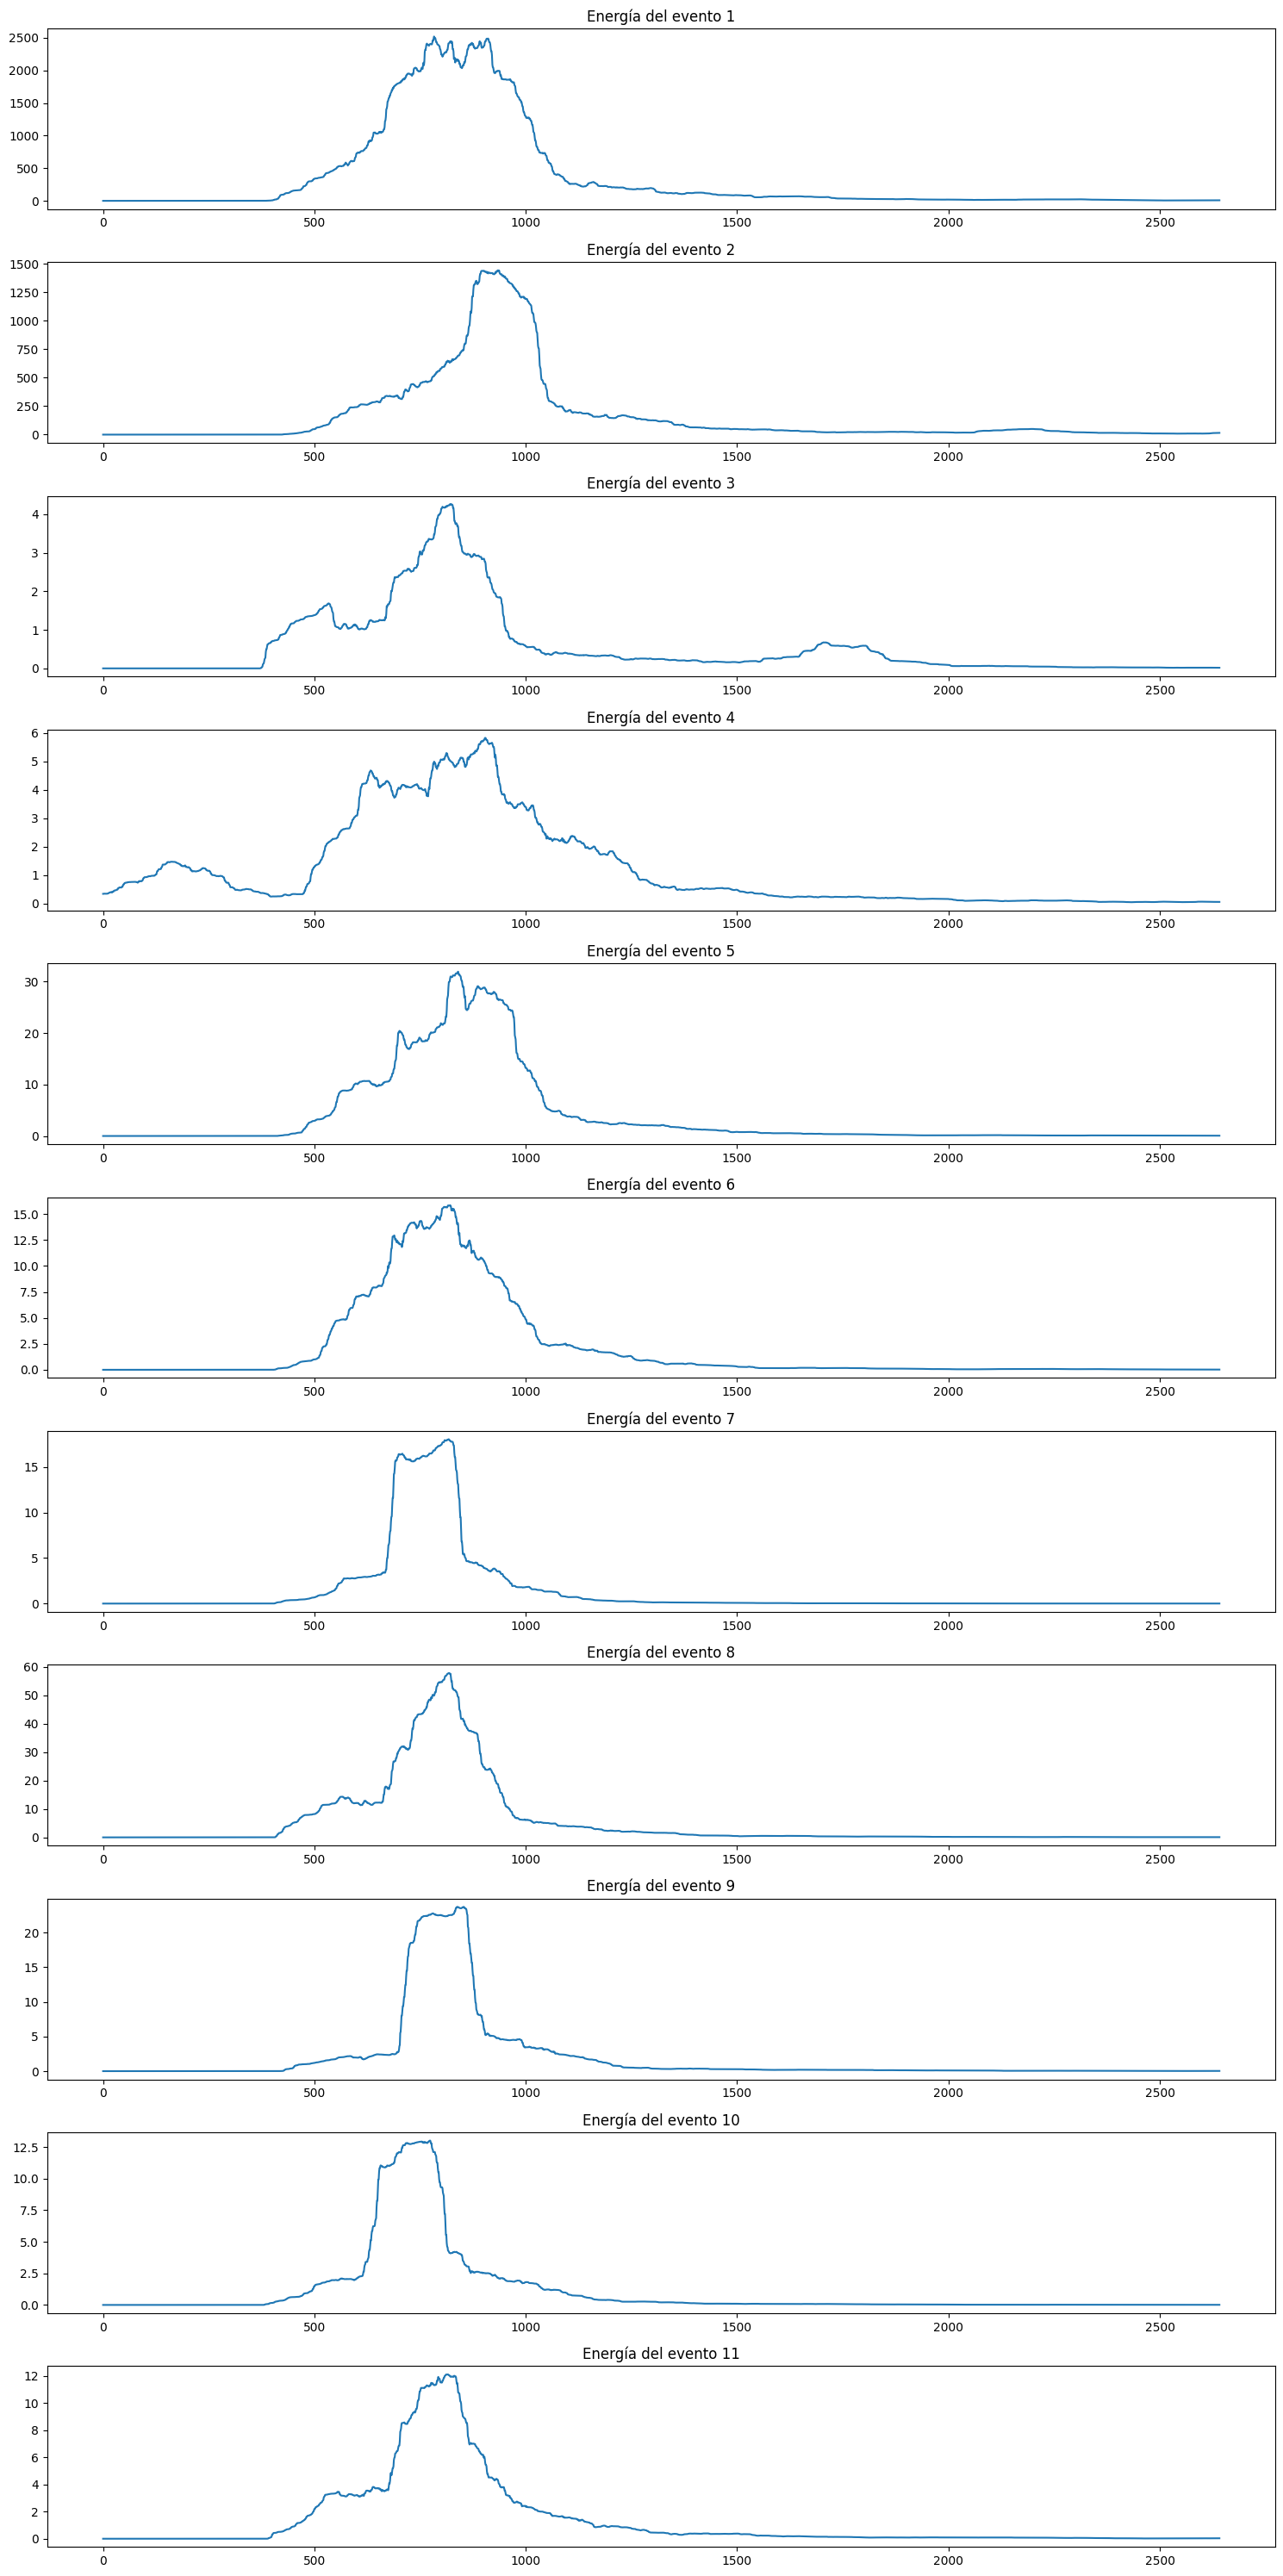

In [35]:
energies_events = [energy_power(st.data, window_size=160)[0] for st in sliced_sts]

# Crear una figura para los gráficos
plt.figure(figsize=(15, 30))

# Graficar la energía de cada evento
for i, energ in enumerate(energies_events, start=1):
    plt.subplot(len(energies_events), 1, i)
    plt.plot(energ)
    plt.title(f'Energía del evento {i}')
    plt.tight_layout()

# Mostrar los gráficos
plt.show()


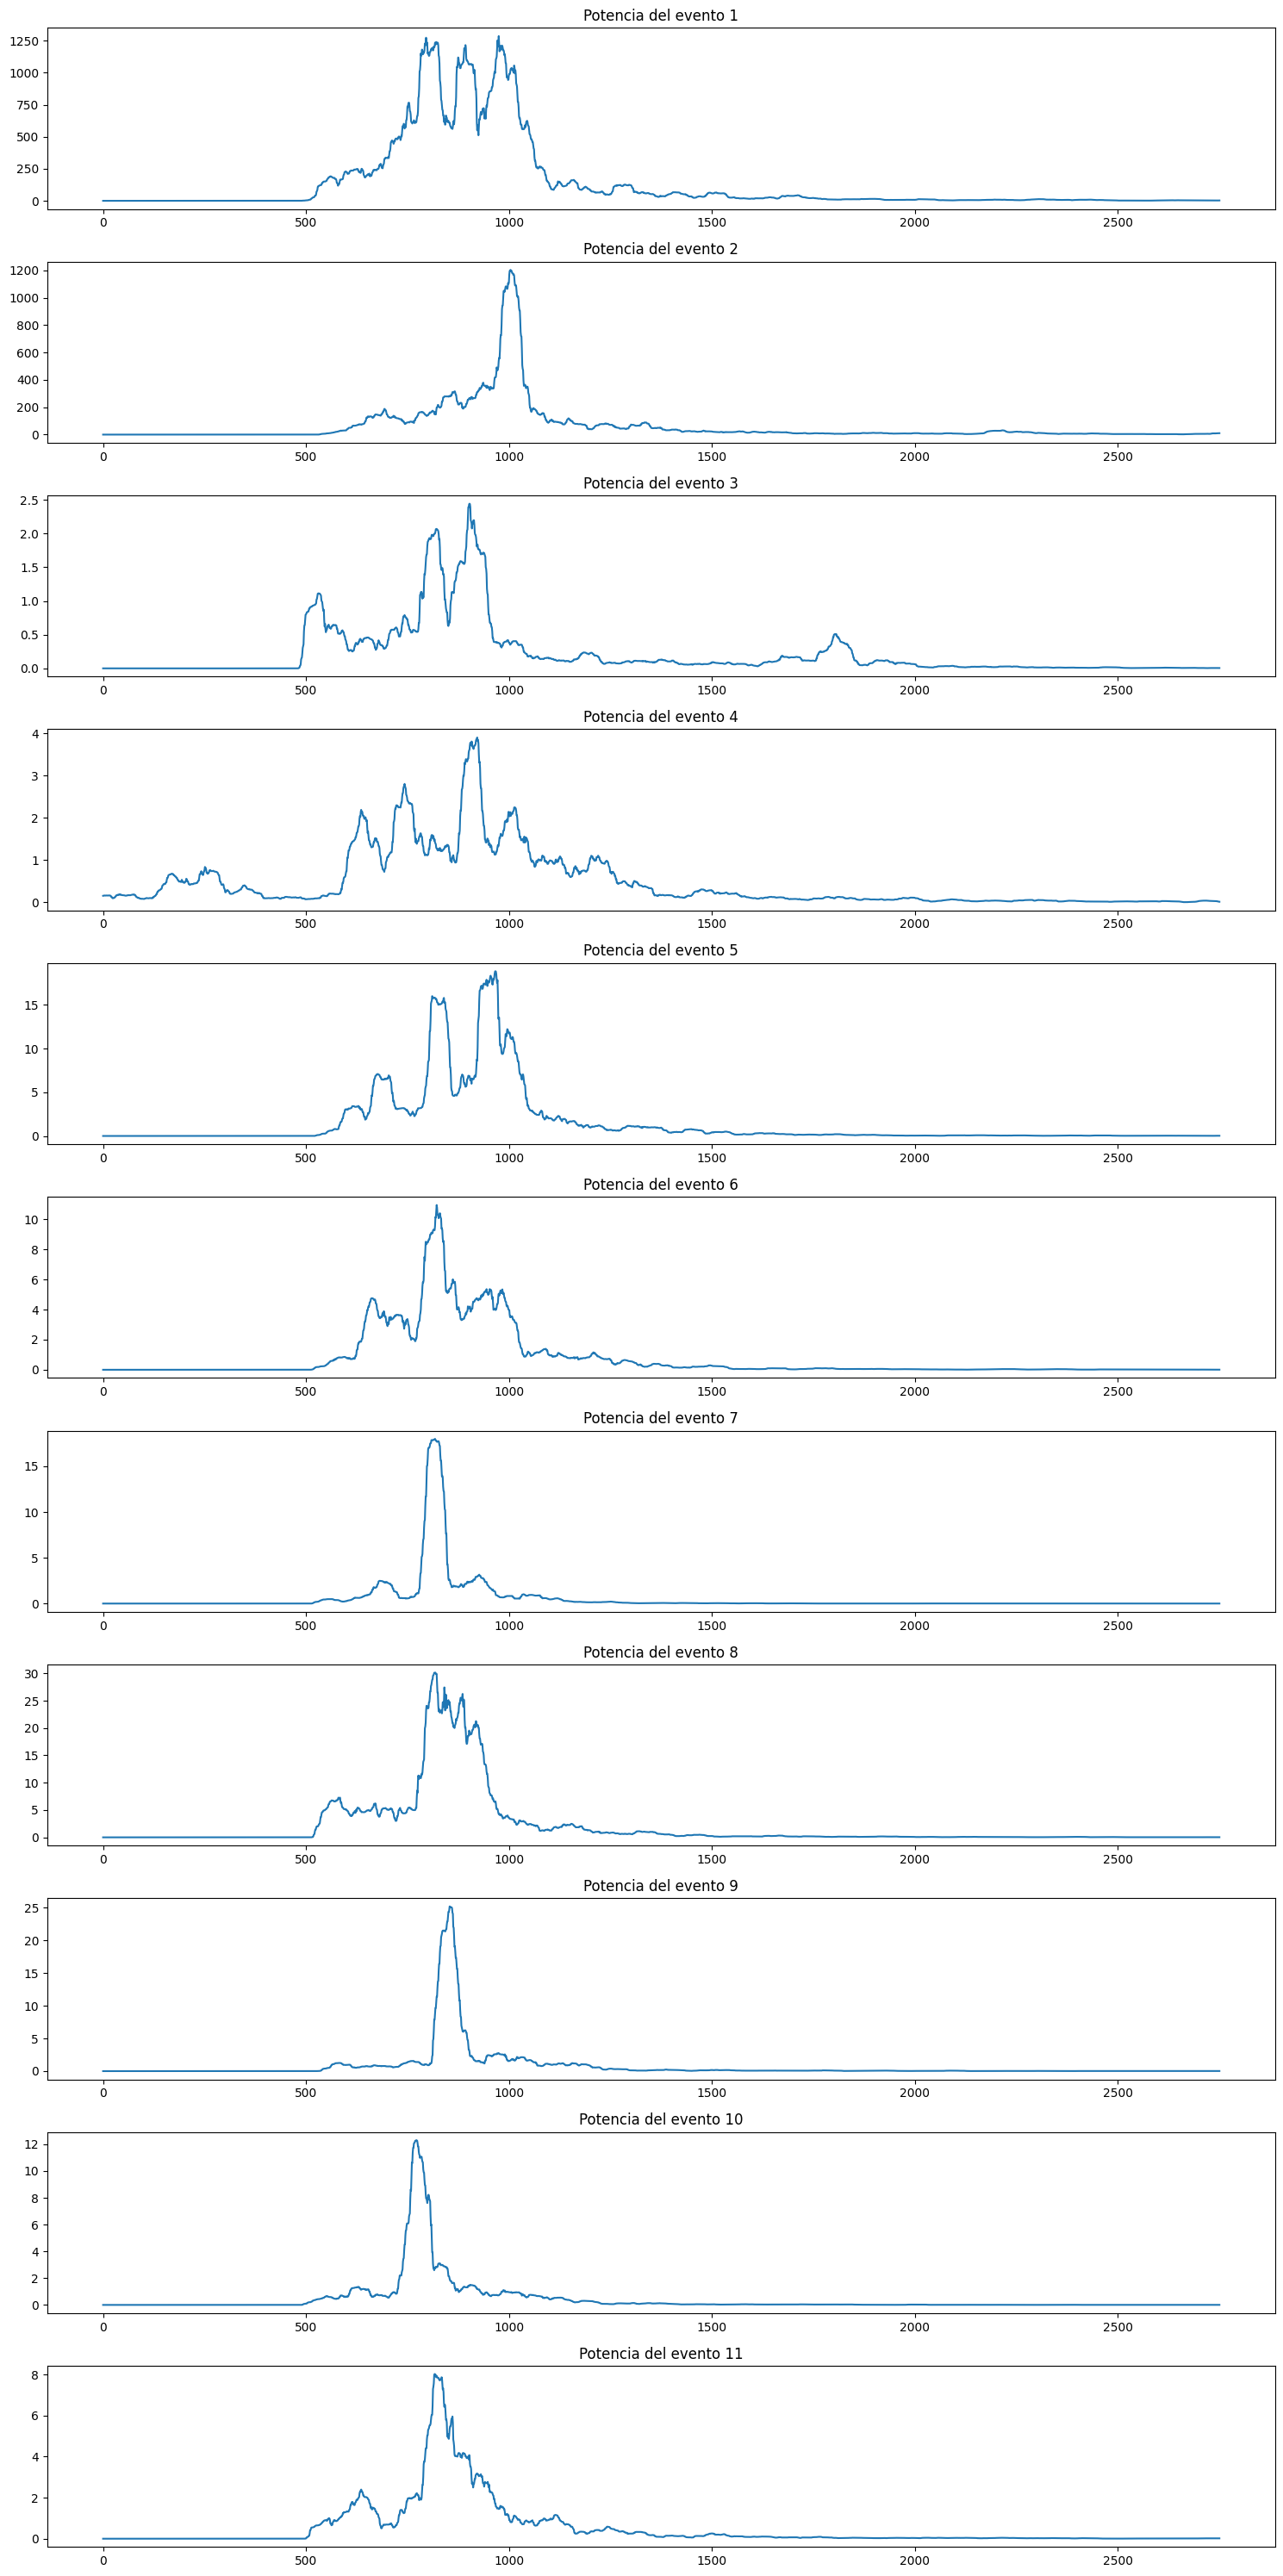

In [36]:
power_events = [energy_power(st.data, window_size=50)[1] for st in sliced_sts]

# Crear una figura para los gráficos
plt.figure(figsize=(15, 30))

# Graficar la energía de cada evento
for i, pw in enumerate(power_events, start=1):
    plt.subplot(len(power_events), 1, i)
    plt.plot(pw)
    plt.title(f'Potencia del evento {i}')
    plt.tight_layout()

# Mostrar los gráficos
plt.show()
